In [3]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from moviepy.editor import VideoFileClip
from operator import itemgetter
from skimage.feature import hog
from skimage.measure import regionprops, label
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import HTML

%matplotlib inline

# HOG Feature Extraction Methods

In [4]:
def GetHOGFeatures(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False):
    """Computes HOG features from an image.
    
    Args:
      img: Numpy array corresponding to image.
      orient: Number of orientation bins.
      pix_per_cell: Size of a cell in pixels.
      cell_per_block: Number of cells in each block.
      vis: Boolean indicating wheather to return image of HOG Features.
    Returns:
      HOG feature vector and image of HOG Features if vis=TRUE.
    """
    if vis:
        feature_vector, hog_img = hog(
            img, 
            orient, 
            (pix_per_cell,)*2, 
            (cell_per_block,)*2, 
            visualise=vis, 
            transform_sqrt=True, 
            feature_vector=True)
        return feature_vector, hog_img
    else:
        feature_vector = hog(
            img, 
            orient, 
            (pix_per_cell,)*2, 
            (cell_per_block,)*2, 
            visualise=vis, 
            transform_sqrt=True, 
            feature_vector=True)
        return feature_vector

def ExtractHOGFeatures(img, orient=9, pix_per_cell=8, cell_per_block=2, color_space=cv2.COLOR_BGR2YCR_CB):
    """Converts image to specified colorspace and then extracts hog features.
    
    Args:
      img: Numpy array corresponding to image.
      orient: Number of orientation bins.
      pix_per_cell: Size of a cell in pixels.
      cell_per_block: Number of cells in each block. 
      color_space: Colorspace in which to perform HOG feature extraction (e.g. cv2.COLOR_BGR2HLS)
    """
    new_img = cv2.cvtColor(img, color_space)
    if len(new_img.shape) == 3:
        feature_vectors = []
        for ch in range(new_img.shape[2]):
            feature_vector = GetHOGFeatures(new_img[:,:,ch], orient, pix_per_cell, cell_per_block, vis=False)
            feature_vectors.append(feature_vector)
        feature_vectors = np.concatenate(feature_vectors)
        return feature_vectors
    else:
        feature_vector = GetHOGFeatures(new_img, orient, pix_per_cell, cell_per_block, vis=False)
    return feature_vectors

# HOG Feature Examples

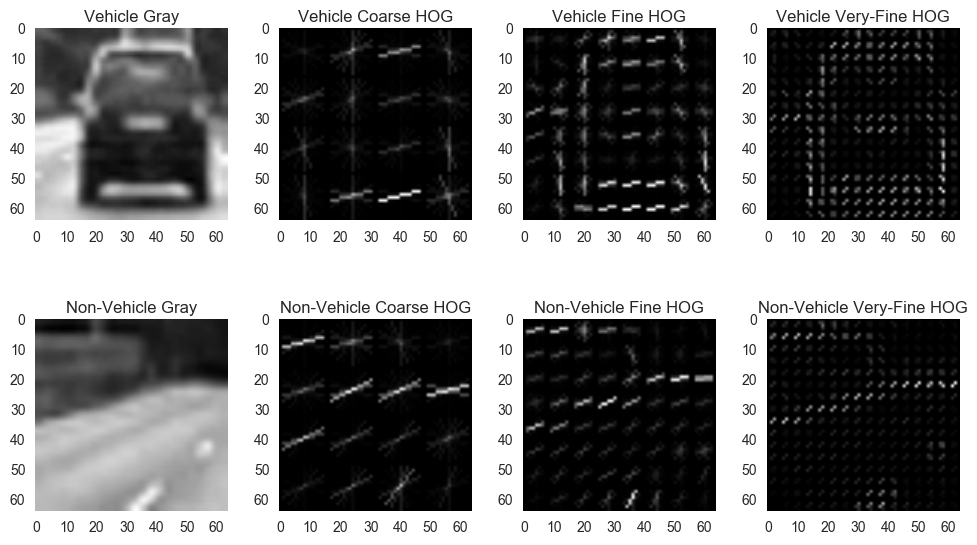

In [5]:
vehicle_img = cv2.imread('vehicles/GTI_MiddleClose/image0037.png')
vehicle_img_gray= cv2.cvtColor(vehicle_img, cv2.COLOR_BGR2GRAY)
_, vehicle_hog_img_coarse = GetHOGFeatures(
    vehicle_img_gray, orient=9, pix_per_cell=16, cell_per_block=2, vis=True)
_, vehicle_hog_img_fine = GetHOGFeatures(
    vehicle_img_gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
_, vehicle_hog_img_very_fine = GetHOGFeatures(
    vehicle_img_gray, orient=9, pix_per_cell=4, cell_per_block=4, vis=True)

non_vehicle_img = mpimg.imread('non-vehicles/GTI/image190.png')
non_vehicle_img_gray = cv2.cvtColor(non_vehicle_img, cv2.COLOR_BGR2GRAY)
_, non_vehicle_hog_img_coarse = GetHOGFeatures(
    non_vehicle_img_gray, orient=9, pix_per_cell=16, cell_per_block=2, vis=True)
_, non_vehicle_hog_img_fine = GetHOGFeatures(
    non_vehicle_img_gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
_, non_vehicle_hog_img_very_fine = GetHOGFeatures(
    non_vehicle_img_gray, orient=9, pix_per_cell=4, cell_per_block=4, vis=True)


fig, ax = plt.subplots(2,4, figsize=(10,6))
ax[0,0].imshow(vehicle_img_gray, cmap='gray')
ax[0,0].grid(False)
ax[0,0].set_title('Vehicle Gray')
ax[0,1].imshow(vehicle_hog_img_coarse, cmap='gray')
ax[0,1].grid(False)
ax[0,1].set_title('Vehicle Coarse HOG')
ax[0,2].imshow(vehicle_hog_img_fine, cmap='gray')
ax[0,2].grid(False)
ax[0,2].set_title('Vehicle Fine HOG')
ax[0,3].imshow(vehicle_hog_img_very_fine, cmap='gray')
ax[0,3].grid(False)
ax[0,3].set_title('Vehicle Very-Fine HOG')

ax[1,0].imshow(non_vehicle_img_gray, cmap='gray')
ax[1,0].grid(False)
ax[1,0].set_title('Non-Vehicle Gray')
ax[1,1].imshow(non_vehicle_hog_img_coarse, cmap='gray')
ax[1,1].grid(False)
ax[1,1].set_title('Non-Vehicle Coarse HOG')
ax[1,2].imshow(non_vehicle_hog_img_fine, cmap='gray')
ax[1,2].grid(False)
ax[1,2].set_title('Non-Vehicle Fine HOG')
ax[1,3].imshow(non_vehicle_hog_img_very_fine, cmap='gray')
ax[1,3].grid(False)
ax[1,3].set_title('Non-Vehicle Very-Fine HOG')

plt.tight_layout()

# Color Histogram Feature Extraction Methods

In [6]:
def ExtractColorHistFeatures(img, bins=32, hist_range=(0,256), color_space=None):
    """Converts image to specified colorspace and computes histogram features.
    
    Args:
      img: Numpy array corresponding to image.
      bins: Number of equal-width bins in the given range of input data.
      hist_range: Range of input data.
      color_space: Colorspace in which to perform histogram (e.g. cv2.COLOR_BGR2HLS)
    """
    if color_space is not None:
        new_img = cv2.cvtColor(img, color_space)
    else:
        new_img = img.copy()
    feature_vectors = []
    for ch in range(new_img.shape[2]):
        feature_vector = np.histogram(new_img[:,:,ch], bins=bins, range=hist_range)[0]
        feature_vectors.append(feature_vector)
    feature_vectors = np.concatenate(feature_vectors)
    return feature_vectors

# Color Histogram Examples

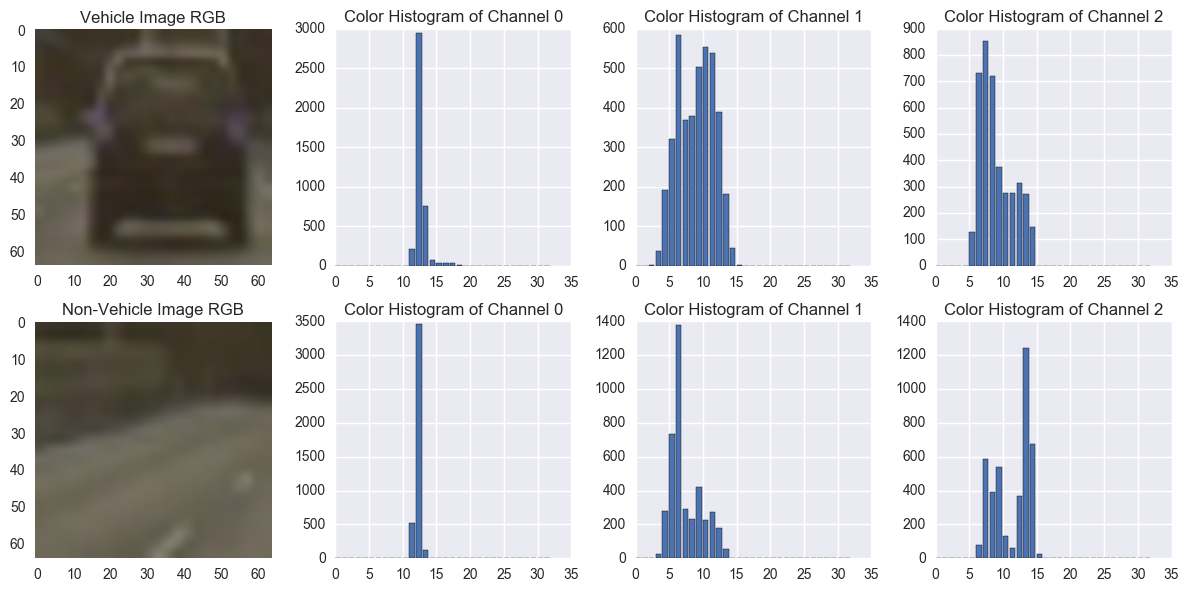

In [7]:
vehicle_img = cv2.imread('vehicles/GTI_MiddleClose/image0037.png')
vehicle_hist_features = ExtractColorHistFeatures(vehicle_img, color_space=cv2.COLOR_BGR2HSV)
vehicle_hist_features = vehicle_hist_features.reshape(3,32)


non_vehicle_img = cv2.imread('non-vehicles/GTI/image190.png')
non_vehicle_hist_features = ExtractColorHistFeatures(non_vehicle_img, color_space=cv2.COLOR_BGR2HSV)
non_vehicle_hist_features = non_vehicle_hist_features.reshape(3,32)

fig, ax = plt.subplots(2,4, figsize=(12,6))
ax[0,0].imshow(vehicle_img)
ax[0,0].grid(False)
ax[0,0].set_title('Vehicle Image RGB')
for ch in range(vehicle_img.shape[2]):
    ax[0,ch+1].bar(np.arange(vehicle_hist_features.shape[1]), vehicle_hist_features[ch,:])
    ax[0,ch+1].set_title('Color Histogram of Channel %d' % ch)


ax[1,0].imshow(non_vehicle_img)
ax[1,0].grid(False)
ax[1,0].set_title('Non-Vehicle Image RGB')
for ch in range(vehicle_img.shape[2]):
    ax[1,ch+1].bar(np.arange(non_vehicle_hist_features.shape[1]), non_vehicle_hist_features[ch,:])
    ax[1,ch+1].set_title('Color Histogram of Channel %d' % ch)
    
plt.tight_layout()

# Feature and Model Construction Methods

In [8]:
def ExtractFeatures(img_dir, orient, pix_per_cell, cell_per_block, hog_color_space, hist_color_space):
    """Given a directory of images constructs and returns feature vectors extracted from each image.
    
    The feature vector extracted from each image is the concatenation of the HOG and Color-histogram features.
    
    Args:
      img_dir: Path to directory with images.
      orient: Number of orientation bins.
      pix_per_cell: Size of a cell in pixels.
      cell_per_block: Number of cells in each block.
      hog_color_space: Colorspace in which to perform HOG feature extraction (e.g. cv2.COLOR_BGR2HLS)
      hist_color_space: Colorspace in which to perform histogram (e.g. cv2.COLOR_BGR2HLS)
    Returns:
      Numpy array with rows corresponding to examples (images) and columns corresponding to features.
    """
    all_features = []
    for img_path in glob.glob('%s/*.png' % img_dir):
        img = cv2.imread(img_path)
        hog_features = ExtractHOGFeatures(
            img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            color_space=hog_color_space)
        hist_features = ExtractColorHistFeatures(
            img, color_space=hist_color_space)
        features = np.concatenate((hog_features, hist_features))
        all_features.append(features)
    return np.vstack(all_features)

def TrainAndEvaluateModel(vehicle_features, non_vehicle_features):
    """Train and Cross-Validate Vehicle/Non-Vehicle Classifier.
    
    Args:
      vehicle_features: Numpy array of vehicle features (rows=examples, columns=features)
      non_vehicle_features: Numpy array of non-vehicle features (rows=examples, columns=features)
    Returns:
      Trained sklearn pipeline consisting of StandardScaler and LinearSVC classifier.  Also returns
        pipelines cross-validation test accuracy.
    """
    # Stack vehicle and non-vehicle feature into feature matrix X
    X = np.vstack((vehicle_features, non_vehicle_features))
    # Generate labels matrix Y (vehicle = 1 and non-vehicle=0)
    Y = np.hstack(([1]*len(vehicle_features), [0]*len(non_vehicle_features)))
    
    # Shuffle examples
    shuffle_idx = np.random.permutation(X.shape[0])
    X = X[shuffle_idx,:]
    Y = Y[shuffle_idx]
    
    # Split shuffled examples into a 80-20 train/test split.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
    
    # Build a pipeline consisting of a feature scaler and a linear SVM classifier.
    # Note, this ensures that scaler parameters are learned from the test set only.
    model_pipeline = Pipeline(
        [('scaler', StandardScaler()), ('svm', LinearSVC(class_weight='balanced'))])
    
    # Perform a grid search for linear SVM C-parameter using 3-fold cross-validation.
    model = GridSearchCV(
        model_pipeline, {'svm__C': [0.001, 0.01, 0.1, 1]}, scoring='accuracy', n_jobs=-1)
    model.fit(X_train, y_train)
    
    # Compute accuracy on held out test set (should match cv test accuracy)
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Extract model with best cross-validation test accuracy.
    performance = pd.DataFrame(model.cv_results_)
    cv_test_accuracy = performance['mean_test_score'].sort_values(ascending=False).iloc[0]
    
    # Return best model with its cross-valiation test accuracy.
    return model, cv_test_accuracy, test_accuracy
    

# Model Performance and Colorspace

In [9]:
# Define list of colorspaces on which to evaluate model performance.
COLOR_SPACES = [('YCrCb', cv2.COLOR_BGR2YCR_CB)]

# For each colorspace save model and cross-validation test accuracy.
performance = []
for col_name, col_space in COLOR_SPACES:
    vehicle_features = []
    for dir_name in ['GTI_Far', 'GTI_Left', 'GTI_Right', 'GTI_MiddleClose']:
        full_path = os.path.join('vehicles', dir_name)
        features = ExtractFeatures(
            full_path, orient=9, pix_per_cell=8, 
            cell_per_block=2, 
            hog_color_space=col_space, 
            hist_color_space=col_space)
        vehicle_features.append(features)
    vehicle_features = np.vstack(vehicle_features)
            
    non_vehicle_features = []
    for dir_name in ['GTI', 'Extras']:
        full_path = os.path.join('non-vehicles', dir_name)
        features = ExtractFeatures(
            full_path, orient=9, pix_per_cell=8, 
            cell_per_block=2, 
            hog_color_space=col_space, 
            hist_color_space=col_space)
        non_vehicle_features.append(features)
    non_vehicle_features = np.vstack(non_vehicle_features)  
    model, cv_test_accuracy, test_accuracy = TrainAndEvaluateModel(vehicle_features, non_vehicle_features)
    performance.append({'model': model, 
                        'cv_test_accuracy': cv_test_accuracy, 
                        'test_accuracy': test_accuracy ,
                        'colorspace': col_name})
    print('Colorspace %s | CV Test Accuracy %f | Test Accuracy %f' % (col_name, cv_test_accuracy, test_accuracy))
    
# Find model with maximum test accuracy and save to disk.
performance_by_accuracy = sorted(performance, key=itemgetter('cv_test_accuracy'), reverse=True)
print('Best Model')
print(performance_by_accuracy[0])
best_model = performance_by_accuracy[0]['model']

Colorspace YCrCb | CV Test Accuracy 0.979285 | Test Accuracy 0.984394
Best Model
{'test_accuracy': 0.98439375750300118, 'colorspace': 'YCrCb', 'model': GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__C': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'cv_test_accuracy': 0.97928549984989488}


# Sliding Windows

In [10]:
def SlidingWindows(x_start_end, win_size, win_overlap):
    """Returns x-coordinate of the top-left corner of square windows of size win_size and overlap win_overlap.
    
    The y-coordinate is always taken to equal 400.
    
    Args:
      x_start_end: Tuple designating start and end of x-coordinate of windows.
      win_size: Size of an edge of the square windows.
      win_overlap: Percentage of window overlap.
    """
    xcs = np.arange(x_start_end[0], x_start_end[1], (1-win_overlap)*win_size)
    return xcs

def DrawWindows(img, x_coords, win_size, color):
    """Displays analysis (sliding) windows on input image for visualization.
    
    Args:
      img: Numpy array corresponding to image.
      x_coords: Numpy array of x-coordinates of the top-left corner of windows.
      win_size: Size of an edge of the square window.
      color: Tuple indicating color with which to display window.
    """
    img = img.copy()
    for xc in x_coords:
        if xc + win_size < img.shape[1]:
            p1 = (int(xc), 400)
            p2 = (int(xc + win_size), int(400 + win_size))
            cv2.rectangle(img, p1, p2, color, 3)   
    return img

# Visual Display of Sliding Windows

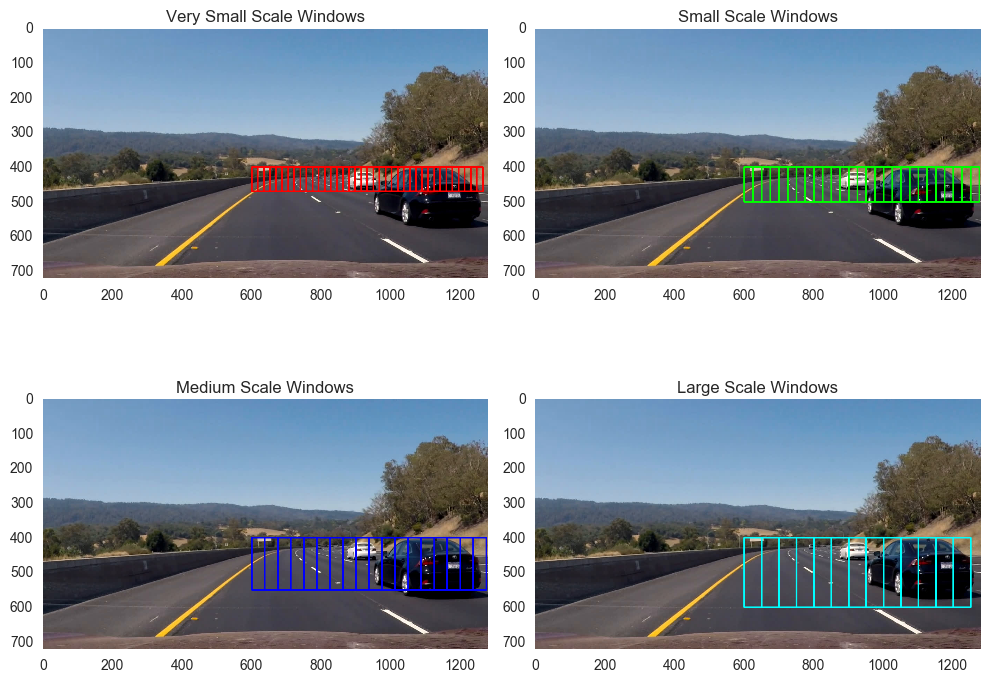

In [11]:
img = cv2.imread('img_seq/frame0750.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

figure, ax = plt.subplots(2,2, figsize=(10,8))

xcs = SlidingWindows((600, 1280), 70, 0.75)
img_draw = DrawWindows(img, xcs, 70, (255,0,0))  

ax[0,0].imshow(img_draw)
ax[0,0].grid(False)
ax[0,0].set_title('Very Small Scale Windows')
   
xcs = SlidingWindows((600, 1280), 100, 0.75)
img_draw = DrawWindows(img, xcs, 100, (0,255,0))  

ax[0,1].imshow(img_draw)
ax[0,1].grid(False)
ax[0,1].set_title('Small Scale Windows')

xcs = SlidingWindows((600, 1280), 150, 0.75)
img_draw = DrawWindows(img, xcs, 150, (0,0,255))  

ax[1,0].imshow(img_draw)
ax[1,0].grid(False)
ax[1,0].set_title('Medium Scale Windows')

xcs = SlidingWindows((600, 1280), 200, 0.75)
img_draw = DrawWindows(img, xcs, 200, (0,255,255))  

ax[1,1].imshow(img_draw)
ax[1,1].grid(False)
ax[1,1].set_title('Large Scale Windows')

plt.tight_layout()
plt.show()


# Vehicle Detection

In [12]:
class VehicleDetector():
    """Object for detecting vehicles in a video."""
    def __init__(self, model, number_detect, windows, sizes, num_frames):
        """Constructor.
        
        Args:
            model: Model trained to differentiate between vehicle and non-vehicle images.
            number_detect: Minimum number of times a pixel must be flagged as part of vehicle to be a member
              of the final vehicle bounding box.
            windows: List of numpy arrays.  Each array contains the x-coordinate of the top-left corner of 
              of square analysis windows of a particular size.
            sizes: List of the analysis window sizes.
            num_frames: Number of frames analyzed in order to determine vehicle bounding box.
        """
        self.buffer_size = num_frames
        self.buffer = [np.zeros((720, 1280, 1))]*self.buffer_size
        self.model = model
        self.windows = windows
        self.sizes = sizes
        self.threshold = number_detect
        self.frame_number = 0
        
    def reset(self):
        self.frame_number = 0
        
    def detect_vehicles(self, img):
        """Find vehicles in a video frame.
        
        Args:
          img: Numpy array corresponding to input video frame.
        """
        # Image whose pixels will count number of times a pixel is a member of a window classified as a vehicle.
        # This image corresponds to a detection heat map for the current frame.
        detect_img = np.zeros((img.shape[0],img.shape[1],1))
        # Image on which bounding box will be displayed.
        img_out = img.copy()
        # Image on which all triggered detections will be displayed.
        img_all_detect = img.copy()
        # Loop over analysis windows of each size and position.
        for window, size in zip(self.windows, self.sizes):
            for xc in window:
                if xc + size < img.shape[1]:
                    # Extract subimage corresponding to window.
                    p1 = (int(xc), 400)
                    p2 = (int(xc + size), int(400 + size))
                    img_win = img[p1[1]:p2[1],p1[0]:p2[0]].copy()
                    # Resize image to 64x64 expected by model.
                    img_win = cv2.resize(img_win, (64,64))
                    # Extract HOG Features
                    hog_features = ExtractHOGFeatures(
                        img_win, orient=9, pix_per_cell=8, cell_per_block=2, color_space=cv2.COLOR_BGR2YCR_CB)
                    # Extract Color Histogram Features.
                    hist_features = ExtractColorHistFeatures(
                        img_win, color_space=cv2.COLOR_BGR2YCR_CB)
                    # Concatenate Features
                    features = np.concatenate((hog_features, hist_features))
                    # Classify feature vector.
                    pred = model.predict(features.reshape(1,-1))[0]
                    # If classification is a vehicle, update heat map by incrementing detection count for 
                    # pixels in the analysis window.
                    if pred == 1:
                        detect_img[p1[1]:p2[1],p1[0]:p2[0], 0] += 1
                        cv2.rectangle(img_all_detect, p1, p2, (0,0,255), 3)

        # Add heat map of current frame to buffer of heat maps from the most recent frames.
        self.buffer[self.frame_number % self.buffer_size] = detect_img
        self.frame_number += 1
        
        # Sum pixel counts across heat maps of the most recent frames to generate and aggregated heat map.
        heat_map = np.sum(np.concatenate(self.buffer, axis=2),axis=2)
        
        # Find pixels involved in more than minimum number of required detections in aggregated heat map.
        img_labels = label( heat_map > self.threshold, neighbors=8)
        
        # Extract bounding box using connected-components analysis and display on input frame.
        props = regionprops(img_labels)
        for prop in props:
            cv2.rectangle(img_out, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255,255,0), 3)
            
        # Return img with bounding box as well as detection heat map.
        return img_out, img_all_detect, heat_map


# Example Vehicle Detections From Single Frames
## Here detections are not consolidated into a single bounding box.

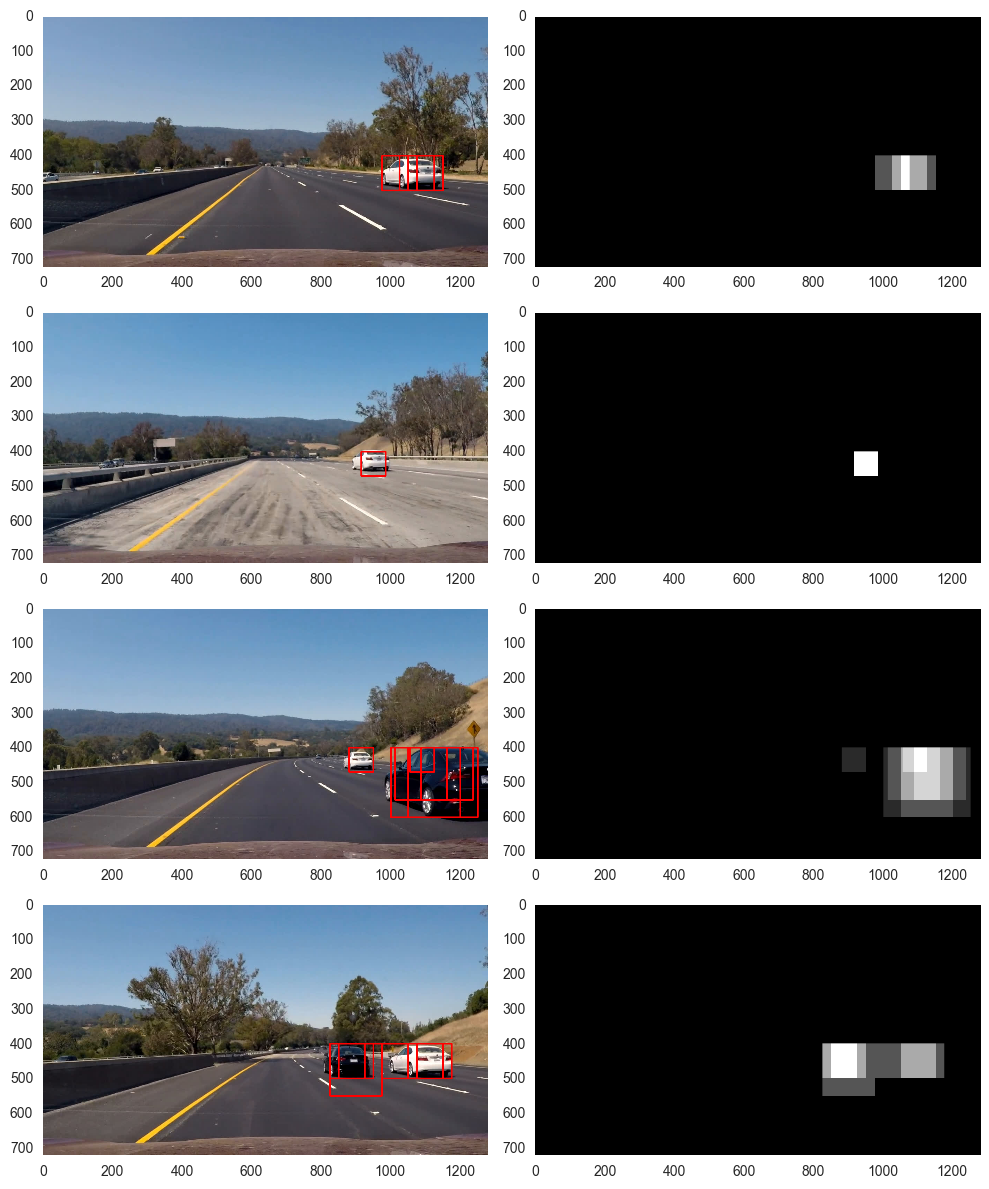

In [13]:
# Define analysis windows
very_small_windows = SlidingWindows((600, 1280), 70, 0.75)
small_windows = SlidingWindows((600, 1280), 100, 0.75)
medium_windows = SlidingWindows((600, 1280), 150, 0.75)
large_windows = SlidingWindows((600, 1280), 200, 0.75)

# Example of detecting vehicle using small analysis windows.
img = cv2.imread('img_seq/frame0360.jpeg')
vehicle_detector = VehicleDetector(
    best_model, 1, [very_small_windows, small_windows, medium_windows, large_windows], [70, 100, 150, 200], 1)
bbox_image, all_detect_image, heat_map = vehicle_detector.detect_vehicles(img)

figure, ax = plt.subplots(4,2, figsize=(10,12))
ax[0,0].imshow(cv2.cvtColor(all_detect_image, cv2.COLOR_BGR2RGB))
ax[0,0].grid(False)
ax[0,1].imshow(heat_map, cmap='gray')
ax[0,1].grid(False)

# Example of detecting vehicle using very small analysis windows.
img = cv2.imread('img_seq/frame0560.jpeg')
vehicle_detector.reset()
bbox_image, all_detect_image, heat_map = vehicle_detector.detect_vehicles(img)

ax[1,0].imshow(cv2.cvtColor(all_detect_image, cv2.COLOR_BGR2RGB))
ax[1,0].grid(False)
ax[1,1].imshow(heat_map, cmap='gray')
ax[1,1].grid(False)

# Example of detecting two vehicle using different scale analysis windows.
img = cv2.imread('img_seq/frame0730.jpeg')
vehicle_detector.reset()
bbox_image, all_detect_image, heat_map = vehicle_detector.detect_vehicles(img)

ax[2,0].imshow(cv2.cvtColor(all_detect_image, cv2.COLOR_BGR2RGB))
ax[2,0].grid(False)
ax[2,1].imshow(heat_map, cmap='gray')
ax[2,1].grid(False)

# Example of detecting two vehicle using similar scales.
img = cv2.imread('img_seq/frame0955.jpeg')
vehicle_detector.reset()
bbox_image, all_detect_image, heat_map = vehicle_detector.detect_vehicles(img)

ax[3,0].imshow(cv2.cvtColor(all_detect_image, cv2.COLOR_BGR2RGB))
ax[3,0].grid(False)
ax[3,1].imshow(heat_map, cmap='gray')
ax[3,1].grid(False)

plt.tight_layout()
plt.show()  

# Vehicle Detection in Video

In [14]:
# Define VideoDetector object that will process video frames.
# This object will consider the 10 most recent frames when defining the bounding box.  Furthermore, pixels that
# fall within the bounding box must each have been a member of an analysis window declared as a vehicle at least 10
# times.
vehicle_detector = VehicleDetector(
    best_model, 10,
    [very_small_windows, small_windows, medium_windows, large_windows], 
    [70, 100, 150, 200], 10)

def process_img(img):
    # Use global video detection object.
    global vehicle_detector
    # Convert input to BGR format as expected by the pipeline.
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Detect vehicles in the frame and draw bounding box.
    img_detect, _, _ = vehicle_detector.detect_vehicles(img)
    # Convert back to RGB format.
    img_detect = cv2.cvtColor(img_detect, cv2.COLOR_BGR2RGB)
    return img_detect

In [15]:
processed_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(process_img)
%time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 6min 57s, sys: 14.6 s, total: 7min 11s
Wall time: 7min


# Example Vehicle Bounding Boxes From Processed Video  

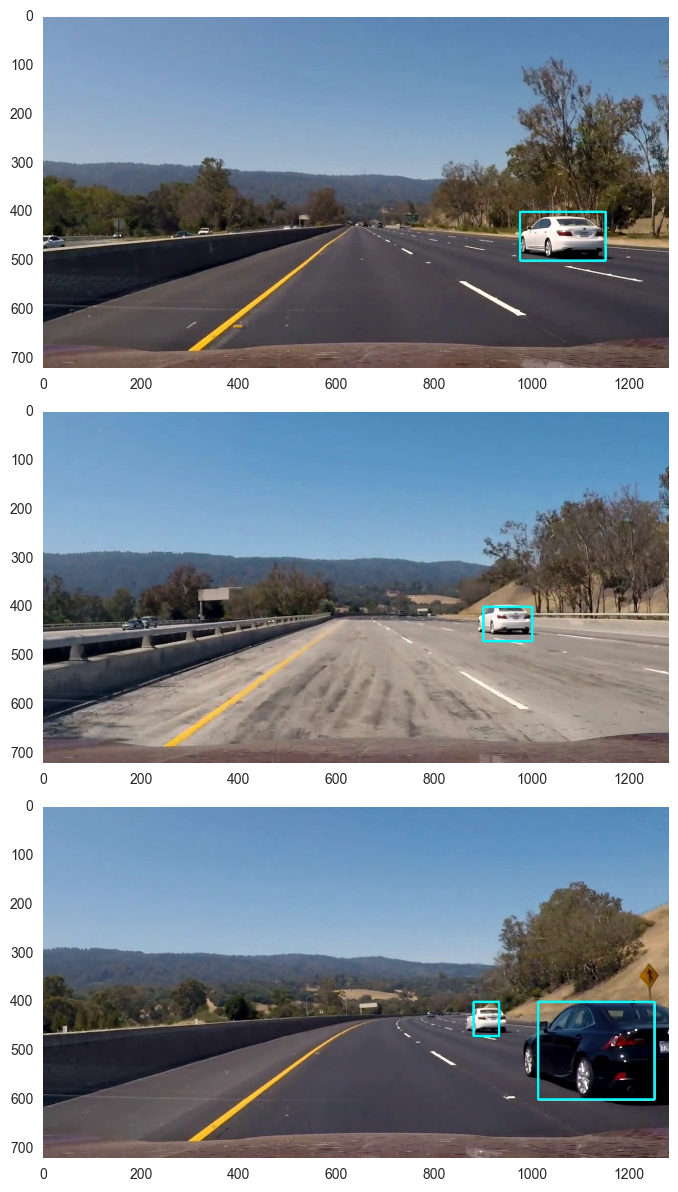

In [16]:
# Example of small bounding box.
img = mpimg.imread('img_output_seq/frame0360.jpeg')

figure, ax = plt.subplots(3,1, figsize=(10,12))
ax[0].imshow(img)
ax[0].grid(False)

# Example of very small bounding box.
img = mpimg.imread('img_output_seq/frame0560.jpeg')

ax[1].imshow(img)
ax[1].grid(False)

# Example of two bounding boxes of different scales.
img = mpimg.imread('img_output_seq/frame0730.jpeg')

ax[2].imshow(img)
ax[2].grid(False)

plt.tight_layout()
plt.show()  

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))